# 如何在Colab上使用OpenVINO運行影像（語義）分割-ADAS應用

作者： Jack OmniXRI, 2023/5/10  

**註：本程式主要用於 road-segmentation-adas-0001 影像（語義）分割模型，輸入為 [B, C, H, W] （1, 3, 512, 896)，輸出為 [B, C, H, W] (1, 4, 512, 896)， 輸出分類為 BG, Road, Curbs, Marks四類，其它模型則由於 output layer 定義不同暫無法使用。**


# 1.安裝OpenVINO

更新pip並安裝OpenVINO開發者最新版本(2022.3)  
如需指定特殊框架[extras]，如onnx, caffe, tensorflow, tensorflow2, mxnet, kaldi, pytorch等，可自行修改指令，如下範例：  
pip install openvino-dev[onnx,pytorch,tensorflow2]  

註：安裝後會出部份紅字錯誤訊息，如下所示  
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas~=1.5.3, but you have pandas 1.3.5 which is incompatible.

主要是因Colab要求的套件版本和OpenVINO安裝的不同，如沒有使用到這些模組，可暫時忽略這項錯誤，繼續執行下面範例。

In [1]:
import time # 引入時間模組

start = time.time() # 開始計算安裝時間

!python -m pip install --upgrade pip #更新 pip
!pip install openvino-dev # 開始安裝 OpenVINO開發者版最新版本

end = time.time() # 記錄結束時間
print("執行時間：%f 秒" % (end - start)) # 輸出時間計算結果

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 23.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 13.0 MB/s eta 0:00:00
  Created wheel for jstyleson: filename=jstyleson-0.0.2-py3-none-any.whl size=2384 sha256=ed1b60e602c1ef6cc099e957fcef22a12f44a7ef9f8ac91e3695408b569c7efb
  Stored in directory: /root/.cache/pip/wheels/12/51/c6/a1e751db88203e11c6d9ffe4683ca3d8c14b1479639bec1006
Successfully built jstyleson
  Attempting uninstall: networkx
    Found existing installation: networkx 3.1
    Uninstalling networkx-3.1:
      Successfully uninstalled networkx-

列出已安裝套件包（可略過）

In [2]:
#!pip list

# 2.下載影像（語義）分割模型及測試用影像
使用 open model zoo tools 進行下載及轉換模型，若為Intel Pre-Trained Model則不需執行轉換。  

* road-segmentation-adas-0001 4分類（BG, Road, Curbs, Marks）  

更完整模型介紹：https://docs.openvino.ai/latest/omz_models_model_road_segmentation_adas_0001.html  

測試影像來源：https://github.com/openvinotoolkit/openvino_notebooks/blob/main/notebooks/data/image/empty_road_mapillary.jpg

In [3]:
# 使用Open Model Tools下載模型
!omz_downloader --name  road-segmentation-adas-0001
!omz_converter --name  road-segmentation-adas-0001

################|| Downloading road-segmentation-adas-0001 ||################

========== Downloading /content/intel/road-segmentation-adas-0001/FP32/road-segmentation-adas-0001.xml
... 100%, 388 KB, 1046 KB/s, 0 seconds passed

========== Downloading /content/intel/road-segmentation-adas-0001/FP32/road-segmentation-adas-0001.bin
... 100%, 719 KB, 1555 KB/s, 0 seconds passed

========== Downloading /content/intel/road-segmentation-adas-0001/FP16/road-segmentation-adas-0001.xml
... 100%, 541 KB, 1426 KB/s, 0 seconds passed

========== Downloading /content/intel/road-segmentation-adas-0001/FP16/road-segmentation-adas-0001.bin
... 100%, 359 KB, 975 KB/s, 0 seconds passed

========== Downloading /content/intel/road-segmentation-adas-0001/FP16-INT8/road-segmentation-adas-0001.xml
... 100%, 1110 KB, 2315 KB/s, 0 seconds passed

========== Downloading /content/intel/road-segmentation-adas-0001/FP16-INT8/road-segmentation-adas-0001.bin
... 100%, 209 KB, 37377 KB/s, 0 seconds passed

==========

In [4]:
# 下載所需測試圖檔及相關函式庫
!wget -N https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/main/notebooks/data/image/empty_road_mapillary.jpg
!wget -N https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/main/notebooks/utils/notebook_utils.py

--2023-05-09 18:19:39--  https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/main/notebooks/data/image/empty_road_mapillary.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 232468 (227K) [image/jpeg]
Saving to: ‘empty_road_mapillary.jpg’

empty_road_mapillar 100%[===================>] 227.02K  --.-KB/s    in 0.02s   

Last-modified header missing -- time-stamps turned off.
2023-05-09 18:19:39 (9.26 MB/s) - ‘empty_road_mapillary.jpg’ saved [232468/232468]

--2023-05-09 18:19:39--  https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/main/notebooks/utils/notebook_utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubuserconte

# 3. 影像（語義）分割範例

以下範例參考 OpenVINO Notebooks 
003-hello-segmentation.ipynb 修改而得。  
https://github.com/openvinotoolkit/openvino_notebooks/blob/main/notebooks/003-hello-segmentation/003-hello-segmentation.ipynb

## 3.1 引入必要函式庫

In [5]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import sys
from openvino.runtime import Core
from notebook_utils import segmentation_map_to_image

## 3.2 載入及編譯模型
載入及編譯模型並定義輸入及輸出結構。  
註：由於Google Colab只提供Intel Xeon CPU，所以device_name只能設為CPU。

In [6]:
ie = Core()

model = ie.read_model(model="intel/road-segmentation-adas-0001/FP16/road-segmentation-adas-0001.xml")
compiled_model = ie.compile_model(model=model, device_name="CPU")

input_layer_ir = compiled_model.input(0)
output_layer_ir = compiled_model.output(0)

## 3.3 載入待測試影像並轉換格式

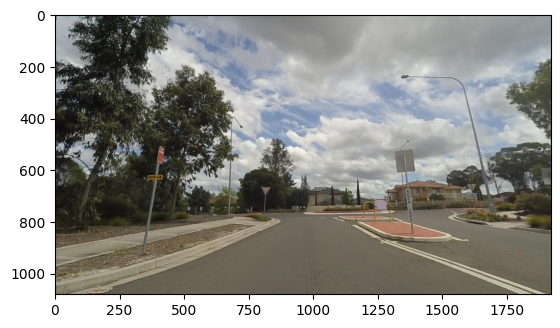

In [7]:
# 讀入待測試之影像，色彩格式為BGR
image = cv2.imread("empty_road_mapillary.jpg")

# 將影像色彩轉換成RGB格式方便後續作業
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_h, image_w, _ = image.shape

# N,C,H,W = 批量大小，色彩通數，影像高度，影像寬度
N, C, H, W = input_layer_ir.shape

# 將影像原始尺寸調整成模型需求輸入尺寸 
resized_image = cv2.resize(image, (W, H))

# 擴增輸入影像維度以滿足模型輸人層定義
input_image = np.expand_dims(
    resized_image.transpose(2, 0, 1), 0
)

# 顯示原始影像
plt.imshow(rgb_image)


## 3.4 進行推論並顯示結果

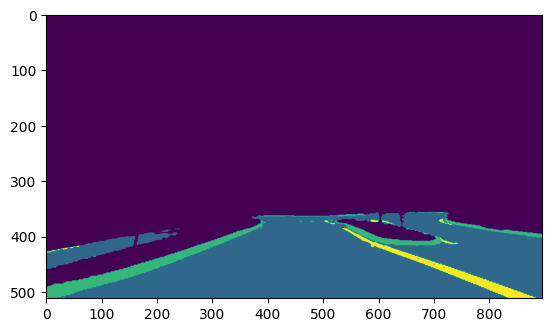

In [8]:
# 進行推論取得結果
result = compiled_model([input_image])[output_layer_ir]

# 準備欲顯示資料
segmentation_mask = np.argmax(result, axis=1)

# 顯示推論結果影像
plt.imshow(segmentation_mask.transpose(1, 2, 0))

## 3.5 準備顯示資料

In [9]:
# 建立色彩轉換表，每個色彩代表一個分類
colormap = np.array([[68, 1, 84], [48, 103, 141], [53, 183, 120], [199, 216, 52]])

# 定義遮罩透明度
alpha = 0.3

# 利用 notebook_utils.py 轉換遮罩色彩
mask = segmentation_map_to_image(segmentation_mask, colormap)
resized_mask = cv2.resize(mask, (image_w, image_h))

# 疊合遮罩和原始影像
image_with_mask = cv2.addWeighted(resized_mask, alpha, rgb_image, 1 - alpha, 0)

## 3.6 將結果可視化

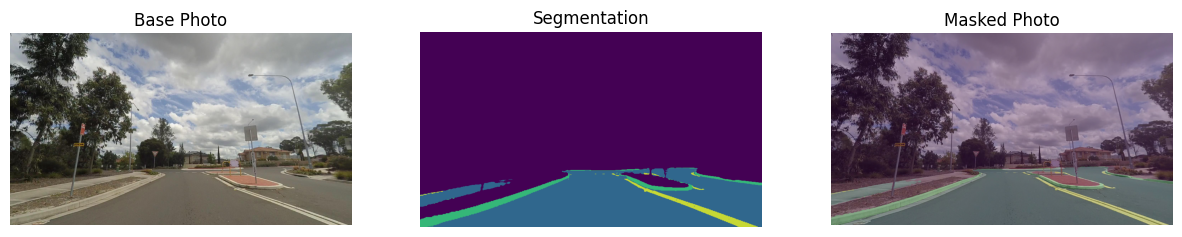

In [10]:
# 定義標題及對應影像
data = {"Base Photo": rgb_image, "Segmentation": mask, "Masked Photo": image_with_mask}

# 建立子畫格以顯示結果
fig, axs = plt.subplots(1, len(data.items()), figsize=(15, 10))

# 填入子畫格內容
for ax, (name, image) in zip(axs, data.items()):
    ax.axis('off')
    ax.set_title(name)
    ax.imshow(image)

# 顯示組合好內容
plt.show(fig)